# 6  | Lab session | Team coding: 3D Augmented Reality

**ES143 Computer Vision, Harvard University**

**Due at the end of lab session (Mar. 7 & Mar. 8)**

Name: *(<font color=red>Sedik Sadik, Ashley Redhead, Nico Fidalgo</font>)*

<br>

---

*When you are done solving this assignment, submit your `.zip` and `.html` files to the appropriate assignment on Canvas. Instructions for generating and naming the `.html` and the `.zip` files are [at the bottom of this notebook](#submission).*

---

In this team coding task you will:
* Practice defining and applying linear transformations in three-dimensions
* Create simple augmented reality images and videos

To maximize your learning, you and your teamate(s) must each create and submit your own notebooks. However, this task is an open collaboration between you and your teamate(s), so it is encouraged for you to work together, for example by dividing up tasks, sharing snippets of code with each other, and helping each other with strategy and debugging.

As usual, use of generative AI tools must adhere to the course policy as described in the [ES 143 Syllabus](https://canvas.harvard.edu/courses/129415/assignments/syllabus). In particular:
* You may not submit AI-generated code that you cannot explain, or whose validity and correctness you have not verified.
* Your use of generative AI tools must be documented in [this text cell](#ai-disclosure) at the bottom of the notebook.

Small items marked with "<font color='red'>**To Do**</font>" require you to act and think but will not be evaluated. Sections marked with "<font color='red'>**TASK ##**</font>" will be evaluated.

### Getting started

The input image and data file referenced in this assignment to complete the assignment can be found in the `.zip` that accompanies this notebook on Canvas. If you have not already done so, begin by creating copies of the notebook and the `.zip` file in your google drive. The filepaths for this assignment should be

`My Drive/es-143-assignments/L06/6_3DAR.{ipynb,zip}`

It is important that the `.zip` file is in the same folder as the notebook before you run the first cell below.


### When you are done

1. Post your AR image(s) and video(s) to [padlet](https://padlet.com/zickler/first_3D_AR).
2. Have each team member submit their `.html` and `.zip` in Canvas. Filenames should be of the form
`LASTNAME1_LASTNAME2_L06-3DAR.{html,zip}`.



# Setup

In [1]:
# Import required libraries here
import cv2                               # OpenCV
import numpy as np                       # numpy
import os
import requests
import pickle
import plotly.express as px
import plotly.graph_objects as go

# Use this line to make matplotlib plot inline (only need to call it once when importing matplotlib)
#%matplotlib inline

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters or use plt.figure(figsize=[H, W]) before specific plots.
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
# # Mount your google drive. This will launch a pop-up window for authentication.

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# YOU SHOULD HAVE ALREADY COPIED OVER THE ASSIGNMENT FILES TO A FOLDER
# TITLED "~/es-143-assignments/L06/" ON YOUR GOOGLE DRIVE

# %cd "/content/drive/My Drive/es-143-assignments/L06/"

In [4]:
# Extract zip file. This results in a directory named ./data/
#! unzip -n 6_3DAR.zip

## Helper functions: `in2hom()`, `hom2in()`

We provide two helper functions that you have seen before:

* `Xout = in2hom(Xin)`: converts an $N\times m$ array of inhomogeneous coordinates (one point per row) to an $N\times (m+1)$ of homogeneous coordinates by appending a column of ones.
* `Xout = hom2in(Xin)`: converts an $N\times m$ array of homogeneous coordinates (one point per row) to an $N\times (m-1)$ of inhomogeneous coordinates by dividing by the right-most column.


In [5]:
# Convert from Nxm inhomogeneous to Nx(m+1) homogeneous coordinates
def in2hom(X):
    return np.concatenate([X, np.ones((X.shape[0], 1), dtype=np.float32)], axis=1)

# Convert from Nxm homogeneous to Nx(m-1) inhomogeneous coordinates
def hom2in(X):
    return X[:, :-1] / X[:, -1:]

In [6]:
#@title Load image and camera matrix

with open('data/twoboards_withcalibration.pkl', 'rb') as f:
    data = pickle.load(f)
img_pts2D = data['img_pts2D']
world_pts3D = data['world_pts3D']
P = data['camera_matrix']

scene_image = cv2.imread('data/twoboards.jpg')
scene_image = cv2.cvtColor(scene_image, cv2.COLOR_BGR2RGB)

# Demonstrations

As in a previous notebook, you are provided with an image <tt>twoboards.jpg</tt>. You are also given a pickle file <tt>twoboards_withcalibration.pkl</tt> that includes a $3\times 4$ camera matrix ${\bf P}$ in addition to the coordinates of $N$ corresponding 2D and 3D points. As before, the coordinates of these points are stored in an $N\times 2$ numpy array `img_pts2D` that has rows $(x_i,y_i)$ and a $N\times 3$ numpy array `world_pts3D` that has corresponding rows $(X_i,Y_i,Z_i)$.

## Demonstration 1: Projecting world points with the camera matrix

The first demonstration is the same as you've seen in a previous notebook. It verifies the accuracy of the camera matrix by using it to project each 3D point ${\bf X}_i=(X_i,Y_i,Z_i,1)$ into the image via ${\bf x}_i'={\bf P}{\bf X}_i$ and then plotting the ${\bf x}_i'$ points along with the original 2D points ${\bf x}_i=(x_i,y_i)$ that they are supposed to be close to.

<font color='red'>**To Do**</font>: Study this code carefully and make sure you understand what it is doing. This understanding will be important for your augmented reality task.

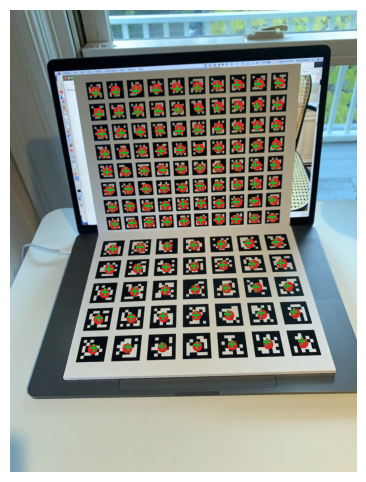

In [7]:
proj = hom2in(np.dot(P, in2hom(world_pts3D).T).T)

# display image and image points
fig,ax =  plt.subplots(figsize=(8,6))
plt.imshow(scene_image / 255.0, cmap="gray")

#What do the circle scatter points and the cross scatter points each represent?
ax.scatter(img_pts2D[:,0], img_pts2D[:,1], marker='o', color='#d62728')
ax.scatter(proj[:,0], proj[:,1], marker='+', color='#2ca02c')

plt.axis('off')
plt.show()

## Demonstration 2: Defining the virtual object

Your task will be to insert a virtual 3-D object into your scene using the camera matrix along with appropriate similarity transformations (i.e., rotations, translations and isotropic scalings) that you design.

The following cell defines a virtual 3D unit pentahedron that will serve as your virtual object, and it draws it in an interactive 3D plotly figure.

<font color='red'>**To Do**</font>: Study this code carefully and make sure you understand what it is doing. This understanding will be important for your augmented reality task.

In [8]:
#  Vertices (5): four vertices that form a square, unit-length base in the xy-plane,
#    and a fifth vertec for the apex.
pentV = np.array([[-1/2, -1/2, 0],      # vertex 0: base bottom-left
                 [1/2, -1/2, 0],        # vertex 1: base bottom-right
                 [1/2, 1/2, 0],         # vertex 2: base top-right
                 [-1/2, 1/2, 0],        # vertex 3: base top-left
                 [0, 0, np.sqrt(3)/2]]) # vertex 4: apex

#  Faces (6): Each triangular face consists of a set of three indices to rows in pentV.
#  Note there are two faces required to cover the square base
pentF = np.array([[0,2,1],  # base
                  [0,3,2],  # base
                  [0,1,4],
                  [1,2,4],
                  [2,3,4],
                  [3,0,4]])

#  Colors (6): Each triangular face (row) in pentF has a color associated with it.
#  We use the default colors in plotly because they aren't ugly, and we assign the same
#  color to the two faces that cover the base
pentC = ('#1f77b4',  # muted blue (base)
           '#1f77b4',  # muted blue (base)
           '#ff7f0e',  # safety orange
           '#2ca02c',  # cooked asparagus green
           '#d62728',  # brick red
           '#9467bd') # muted purple

# Study how this code works -- you will need to copy and adapt it for the following tasks
fig3 = go.Figure()

fig3.add_trace(go.Mesh3d(

    opacity=1.0,  # 1 is opaque; 0 is invisible

    # vertices
    x=pentV[:,0],
    y=pentV[:,1],
    z=pentV[:,2],

    # faces
    i=pentF[:,0],
    j=pentF[:,1],
    k=pentF[:,2],

    # colors
    facecolor=pentC,
))

fig3.show()

# <font color='red'>**TASK 1**</font>. Create an augmented reality image

Your task is to display the image `twoboards.jpg` with the pentahedron virtually superimposed so that it appears to be resting on one of the board planes. Specifically, you are to complete the function `place_pentahedron(corners)`, using the following steps. `place_pentahedrons` takes in the input `corners` which is a $4\times 3$ matrix consisting of the coordinates of four 3D points $(X_j,Y_j,Z_j), j=1,\ldots 4$ that defined the target location of the virtual pentahedron's base points within the 3D scene. (These points are assumed to be ordered clockwise when viewing the pentahedron from above.)

Your function must perform the following steps:
1. Define and calculate the parameters of transformation of the pentahedron. These parameters include variables corresponding to scale, translation and rotation of the pentahedron. Note that since all transformations are done with respect to the origin, all transformations are relative to the center of the base of the square face of the pentahedron.
  - Scale should relate the side length of the base of the pentahedron to the distance between respective elements of `corners`
  - Translation should relate the location of the center of the base of the pentahedron to the centroid of `corners`
  - Rotation should relate the normal of the base of the pentahedron to the normal of `corners`.
2.  Apply the scale, shift and rotation calculated previously to the $5\times 3$ vertices of the pentahedron `pentV`, resulting in `pentV_onbox`, a translation of `pentV` into the world coordinates.
3. Use the camera matrix `P` to project the 3D pentahedron points `pentV_onbox` to their corresponding 2D image points  `pentV_proj`.
4. Draw the projected pentrahedron points `pentV_proj` and their colored triangular faces on top of the image, using the helper fuction `plot_pentV_proj()` that we provide. (This step is already implemented for you in the starter code.)

Use the [Corner Selection](#corner-selection) cell below to interactively choose four interesting 3D points to use for the input `corners`.

Test your function by executing the [Test Script](#test-script-1) cell below. Choose the Modify the corners given in this code snippet and upload your placed pentahedron on padlet.

In addition, some (optional) code has been provided for debugging the coordinates of `pentV_onbox` in 3D world space if you are having trouble aligning your pentahedron to the calibration board.

In [9]:
#@title Helper function: `plot_pentV_proj()`
def plot_pentV_proj(pentV_proj):
  plt.figure();
  plt.clf();
  plt.imshow(scene_image / 255.0, cmap="gray")
  #plt.scatter(img_pts2D[:,0],img_pts2D[:,1])
  plt.axis('off')

  for i in range(5):
      # draw ith triangular face, projected into image
      plt.fill(pentV_proj[pentF[i,:],0], # projected x-coords for this face
          pentV_proj[pentF[i,:],1],     # projected y-coords for this face
          color=pentC[i],               # color for this face
          alpha=0.5)                    # transparency: 1=opaque; 0=invisible
  return plt.gcf();



<a name="debug-script-1"></a>
## Optional debugging code

This debugging script plots `pentV_onbox` in world coordinates. If you want to make sure that you have calculated completed steps 1 and 2 correctly before proceeding to steps 3 and 4, run this code **after** you have defined `pentV_onbox`.

In [10]:
#Helper function - add camera
def add_camera(h,w,camera,raysize,figobj):
# Add tetrahedral camera to pyplot figure
# h,w:      height and width of image in pixels
# camera:   3x4 camera matrix
# raysize:  length of tetrahedral edges (in world units)
# fig:      pyplot figure object
#
# Returns: 1
#
# Uses anatomy of camera matrices from Hartley and Zisserman Chapter 6

    # normalize camera such that bottom-left three-vector
    #   corresponds to unit-length principal ray in front of camera (HZ Section 6.2.3)
    camera=camera*np.sign(np.linalg.det(camera[:,0:3]))/np.linalg.norm(camera[2,0:3])

    # Compute camera center (null vector of P)
    _, _, v = np.linalg.svd(camera)
    C = np.transpose(v[-1,0:3]) / v[-1,3]

    # Back-project image corners to unit-length 3D ray segments:
    S = np.array([[0, 0, 1],       # homog image coords if top left pixel
                  [0, h-1, 1],     # bottom left
                  [w-1, h-1, 1],   # bottom right
                  [w, 0, 1]])      # top right

    #   HZ equation (6.14): compute one 3D point along each ray
    X = np.transpose(np.linalg.lstsq(
        camera[:,0:3],
        np.transpose(S)-np.expand_dims(camera[:,3],axis=1),
        rcond=None)[0])

    #   unit-vectors from camera center to each 3D point
    V = X - np.tile(C, (4, 1))
    V = V / np.linalg.norm(V, ord=2, axis=1, keepdims=True)

    # make sure these vectors point forwards from the camera instead of backwards
    V = V*np.expand_dims(np.sign(np.sum(V * np.tile(camera[2,0:3],(4, 1)), axis=1)),axis=1)

    #   desired ray segments that are length raysize in these directions
    V = np.tile(C, (4, 1)) + raysize * V

    # append the camera center itself to complete the four tetrahedral vertices
    V=np.vstack([C,V])

    # add camera center to figure
    figobj.add_trace(go.Scatter3d(
        x=[C[0]],
        y=[C[1]],
        z=[C[2]],
        mode='markers',
        marker=dict(
            size=3,
            color='#ff7f0e'
        )
    )
                    )


    # add tetrahedron to figure
    figobj.add_trace(go.Mesh3d(
        # vertices of tetrahedron
        x=V[:,0],
        y=V[:,1],
        z=V[:,2],

        # i, j and k give the vertices of triangles
        i=[0, 0, 0, 0],
        j=[1, 2, 3, 4],
        k=[2, 3, 4, 1],
        opacity=0.5,
        color='#ff7f0e'
    ))

    return 1


# plot 3D box corners
fig = go.Figure()

# Add scatter plot for 3D box corners
fig.add_trace(go.Scatter3d(
    x=world_pts3D[:,0],
    y=world_pts3D[:,1],
    z=world_pts3D[:,2],
    mode='markers',
    marker=dict(
        size=2,
        color='#1f77b4'
    )
))

# Add mesh plot
fig.add_trace(go.Mesh3d(
    opacity=0.5,

    # vertices: uncomment this to display the object using is transformed coordinates
    x=pentV_onbox[:,0],
    y=pentV_onbox[:,1],
    z=pentV_onbox[:,2],

    # vertices: uncomment this to display the object using its original coordinates
    # x=pentV[:,0],
    # y=pentV[:,1],
    # z=pentV[:,2],


    # faces
    i=pentF[:,0],
    j=pentF[:,1],
    k=pentF[:,2],

    # colors
    facecolor=pentC,
))

# add camera
h,w=scene_image.shape[:2]
add_camera(h,w,P,1,fig)

# Update layout with aspect ratio and initial viewing direction. Getting the
# correct aspect ration is oddly painful in plotly, so the code for this is a little ugly.

# Retreive the ranges of x, y, and z values over all trace points in the figure
x_range = np.ptp([x for trace in fig.data if 'x' in trace for x in trace.x])
y_range = np.ptp([y for trace in fig.data if 'y' in trace for y in trace.y])
z_range = np.ptp([z for trace in fig.data if 'z' in trace for z in trace.z])
max_range = max(x_range, y_range, z_range)

fig.update_layout(
    scene=dict(
        aspectmode='manual',
        aspectratio=dict(x=x_range/max_range,
                         y=y_range/max_range,
                         z=z_range/max_range),
        camera=dict(
            up=dict(x=0, y=-1, z=0),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=-1.5, y=-0.3, z=-1)
        )
    ),
    showlegend=False
)

# Show the plotly figure
fig.show()



NameError: name 'pentV_onbox' is not defined

## Your function here

In [11]:
def place_pentahedron(corners):
  '''
  input: corners- a 4x3 numpy array consisting of the world coordinates of the 4 corners for the base of the pentahedron
  output: a figure (plot) with the pentahedron projected into the image, with the base corners aligned at the input corners
  '''
  A = pentV[3]
  B = pentV[2]
  C = pentV[1]
  D = pentV[0]
  A_prime = corners[3]
  B_prime = corners[2]
  C_prime = corners[1]
  D_prime = corners[0]
  s_numerator = np.linalg.norm(B_prime - A_prime)
  s_denom = np.linalg.norm(B - A)
  S = s_numerator / s_denom
  x_prime = (B_prime - A_prime) / np.linalg.norm(B_prime - A_prime)
  y_prime = (D_prime - A_prime) / np.linalg.norm(D_prime - A_prime)
  z_prime = np.cross(x_prime, y_prime)
  R = np.column_stack([x_prime, y_prime, -z_prime])
  T = np.mean([A_prime, B_prime, C_prime, D_prime], axis=0)
  original = np.column_stack([A, B, C, D])
  rotated_pts = R@(pentV.T)
  scaled_pts = S*rotated_pts
  scaled_pts = scaled_pts.T
  pentV_onbox = scaled_pts + T
  pentV_proj = P @ in2hom(pentV_onbox).T
  pentV_proj = hom2in(pentV_proj.T)
  return pentV_proj



<a name="corner-selection"></a>
## Corner Selection

Your `place_pentahedron()` function requires the coordinates of four 3D points to define the target location of the pentahedron's base in the world coordinate system. The following cell creates an interactive plot that you can use to identify the coordinates of the points you wish to use.

Hover over the plot to reveal the index of each point, and then use this index to obtain its coordinates from the cooresponding row of `world_pts3D`.

In [12]:
import pandas as pd

proj = hom2in(np.dot(P, in2hom(world_pts3D).T).T)

# display image and image points

fig = px.imshow(scene_image / 255.0)

index = np.arange(proj.shape[0])

df = pd.DataFrame({
    'x': proj[:,0],
    'y': proj[:,1],
    'index': index,
})

fig.add_trace(
    px.scatter(df,
        x='x', y='y',
        hover_name = 'index'
    ).data[0]
)

fig.update_layout(showlegend=False)
fig.update_xaxes(visible=False)
fig.update_yaxes(visible=False)
fig.show()

<a name="test-script-1"></a>
## Test Script

Run this cell to test your code. When you are happy with the results, post a copy of your figure to padlet.

In [13]:
coords = np.array([105, 103, 89, 91]) #Feel free to modify the corner selection here

corners = world_pts3D[coords]
image = place_pentahedron(corners)

# <font color='red'>**TASK 2**</font>. Create an augmented reality video

 Using `place_pentahedron`, create a video `.mp4` file of the pentahedron translating across the coarse (lower) calibration board. Specifically:

 * The pentahedron should initially be shown with all four corners on squares of the **coarse** calibration board.
 * The pentahedron should finally be shown with all four corners on squares of the **coarse** calibration board
 * During the video, the pentahedron should smoothly rotate, translate and scale as it moves from the initial to final locations. *Hint:* This can be done using linear interpolation e.g. `np.linspace`.

The video is generated using `cv2.VideoWriter`, a function that takes in images as frames of a video and composites them into a `.mp4`. Your task is to determine the locations of the world coordinates of the corners in each image, and use `place_pentahedron` place the pentahedron in each frame to generate a smooth video.

Some skeleton code has been given to you for generating the video. The video will be found in `videos/pentahedron_video.mp4`.

In [14]:
tl_start = world_pts3D[114]
tr_start = world_pts3D[113]
br_start = world_pts3D[106]
bl_start = world_pts3D[107]
tl_end = world_pts3D[88]
tr_end = world_pts3D[87]
br_end = world_pts3D[80]
bl_end = world_pts3D[81]

tl = np.linspace(tl_start, tl_end, 50)
tr = np.linspace(tr_start, tr_end, 50)
br = np.linspace(br_start, br_end, 50)
bl = np.linspace(bl_start, bl_end, 50)

In [15]:
# Create a folder to store frames
os.makedirs('frames', exist_ok=True)
plt.close('all')

#Your task: Add code so that in the loop at each index i, place_pentahedron outputs a new frame for our video

NUM_FRAMES = 50
for i in range(NUM_FRAMES):
  tmp = np.array([bl[i], br[i], tr[i], tl[i]])
  fig = plot_pentV_proj(place_pentahedron(tmp))
  fig.savefig(f"frames/frame_{i}.png", bbox_inches='tight')
  plt.close(fig)



#### Display code, you should not have to modify anything below this comment  ####
# Use OpenCV to create a video from the frames
os.makedirs('videos', exist_ok=True)
frame_array = []
for i in range(NUM_FRAMES):
    img = cv2.imread(f'frames/frame_{i}.png')
    height, width, layers = img.shape
    size = (width, height)
    frame_array.append(img)

out = cv2.VideoWriter('videos/pentahedron_video.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 10, size)

for i in range(len(frame_array)):
    out.write(frame_array[i])

out.release()

import shutil
shutil.rmtree('frames')


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


<a name="ai-disclosure"></a>
# Disclosure of use of Generative AI for this assignment

<br />

*OPTIONAL TO DO: Write your brief summary of Generative AI use here.*

<br />


<a name="submission"></a>
# Submission

The following cells generate the HTML file of the notebook and an accompanying ZIP file that inlcudes your uploaded `.mp4`'s at filepath

`.submit/LASTNAME1_LASTNAME2_L06-3DAR.{html,zip}`

Once they are generated, submit your `.html` and `.zip` files to the appropriate assignment on Canvas.

**Important**: Remember to edit the filenames (either in the cells below or on your local computer after downloading) to match your and your teammate's name, and make sure that all cells execute properly (i.e., click Runtime -> Restart session and run all) before exporting to HTML.

In [ ]:
!mkdir "submit"

In [ ]:
# Convert to HTML. Before running this cell:
# 1. edit your name in this cell
# 2. make sure your notebook executes and is saved

!jupyter nbconvert --to html 6_3DAR.ipynb --output-dir "submit" --output "3DAR.html"

[NbConvertApp] Converting notebook 6_3DAR.ipynb to html
[NbConvertApp] Writing 1031532 bytes to submit/3DAR.html


In [ ]:
from zipfile import ZipFile

def writeFolder(zip, path):
  import os
  for dirpath,dirs,files in os.walk(path):
    for f in files:
      fn = os.path.join(dirpath, f)
      zip.write(fn)

def writeFile(zip, path):
  zip.write(path)

In [ ]:
# Zip the source. Don't forget to edit your name before running this cell

zipObj = ZipFile('submit/SADIK_REDHEAD_FIDALGO_L06_3DAR.zip', 'w')

writeFolder(zipObj, "videos")
writeFile(zipObj, "6_3DAR.ipynb")

zipObj.close()